In [58]:
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
import copy

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
from catboost import CatBoostRegressor as cat
from sklearn.metrics import r2_score

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

from GPyOpt.methods import BayesianOptimization

In [59]:
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt

# Load Data

In [60]:
df_input = pd.read_pickle('data/CALLS_FINAL.pkl')
#display(df_input.head())
#display(df_input.tail())

In [61]:
target_mtd = pd.read_csv('metadata/target_kospi.csv')
target_mtd['코드'] = target_mtd['코드'].apply(lambda x: str(int(x)).zfill(6))
target_mtd.columns = [x.replace('품목', '기업명') for x in target_mtd.columns]
target_mtd = target_mtd[['코드', '기업명']]
#display(target_mtd.head())
#display(target_mtd.tail())

# Prepare data to feed

In [62]:
# load data
def load_data(ticker, visualize=False) : 

    stock_price = pd.read_pickle('data/kospi/%s.data' % ticker)
    stock_price.index = pd.to_datetime(stock_price.index)
    stock_price = stock_price.drop(['Adj Close'], axis=1)
    #stock_price = pd.DataFrame(stock_price[['Close']])
    #other_components = stock_price[['Open', 'High', 'Low', 'Volume']]
    stock_price

    # merge wihtout time lag
    df = stock_price.merge(df_input, how='inner', left_on=stock_price.index, right_on=df_input.index)
    df.index = df['key_0']
    df = df.drop(['key_0'], axis=1)

    # preprocess (remove object columns)
    for idx_day, day in enumerate(['월요일', '화요일', '수요일', '목요일', '금요일']) : 
        df['요일'] = df['요일'].apply(lambda x : idx_day if x==day else x)
    for column in df.select_dtypes('object').columns : 
        df[column] = df[column].apply(lambda x : x.replace(',', ''))
        df[column] = pd.to_numeric(df[column])

    #display(df)
    if visualize==True : 
        print(df.info())
    return df

In [76]:
ticker = '079430'
df_test = load_data(ticker)

# Run RL

info: {'total_reward': 10010.0, 'total_profit': 0.006272737124940037, 'position': 1}


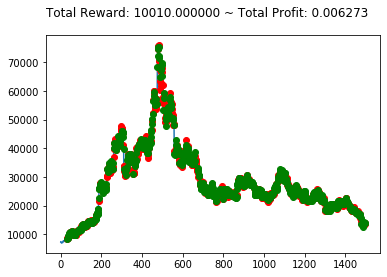

In [77]:
df_target = df_test.copy()

def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = df.drop(['Close'], axis=1).to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features

    
prices, signal_features = my_process_data(df=df_target, window_size=30, frame_bound=(30, len(STOCKS_GOOGL)))
env = MyStocksEnv(prices, signal_features, df=df_target, window_size=30, frame_bound=(30, len(STOCKS_GOOGL)))

observation = env.reset()
while True:
#for _ in range(100) : 
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    #env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
#env.render()
plt.show()